In [104]:
import pandas as pd
import plotly.express as px
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


df = pd.read_csv('stock_data.csv')
data = df[['Date', 'Sector', 'Close']].copy()
data.Date = pd.to_datetime(df.Date, utc=True).dt.tz_convert(None).astype('int64') // 10**9
data = data.groupby(['Date', 'Sector']).mean()
data.reset_index(inplace=True)




In [124]:

X_train, X_test, y_train, y_test = train_test_split(data.drop('Close', axis=1), data.Close)
train_pool = Pool(X_train, label=y_train, cat_features=['Sector'])
test_pool = Pool(X_test, label=y_test, cat_features=['Sector'])
model = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, verbose=100, cat_features=['Sector'])
model.fit(train_pool)
predictions = model.predict(test_pool)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R2: {r2}')

0:	learn: 70.0893940	total: 30ms	remaining: 5.96s
100:	learn: 11.2499493	total: 3.23s	remaining: 3.16s
199:	learn: 9.3751390	total: 6.42s	remaining: 0us
Mean Squared Error: 72.33639303845688
R2: 0.9862572192927742


In [125]:
data_df = X_test.copy().reset_index(drop=True)
data_df['Predicted'] = pd.Series(predictions, name='Predicted').reset_index(drop=True)
data_df['Actual'] = y_test.reset_index(drop=True)


In [126]:
data_df

,Date,Sector,Predicted,Actual
0,1658203200,Financial Services,126.894556,125.615898
1,1702530000,Energy,102.078070,99.542534
2,1694145600,Technology,181.008444,180.352582
3,1736226000,Technology,241.088483,238.905308
4,1611550800,Healthcare,202.606025,200.970360
...,...,...,...,...
3452,1586836800,Energy,36.366494,29.380688
3453,1660104000,Consumer Cyclical,270.943309,275.544737
3454,1704776400,Utilities,76.034516,62.393090
3455,1616126400,Energy,59.950230,60.935565


In [127]:
import plotly.graph_objects as go
import plotly.express as px

data_df.sort_values('Date', inplace=True)
fig = go.Figure()
fig.add_trace(px.scatter(data_df, x='Date', y='Predicted', hover_data='Sector').data[0])
fig.add_trace(px.scatter(data_df, x='Date', y='Actual',color_discrete_sequence=['red'], hover_data='Sector').data[0])
fig.show()

In [128]:
import matplotlib.pyplot as plt

In [129]:
def plots_and_results(x, pred, act):
    """
    Args:
        x: x axis values
        pred: predicted values
        act: actual values

    Returns:
        results: a dict containing the info about the model
    """
    results = {}

    #get residuals, mse, r2

    results['resids'] = act-pred
    results['mse'] = (results['resids']**2).mean()
    results['r2'] = r2_score(act, pred)
    
    #plotting constant variance
    fig = plt.figure()
    plt.scatter(pred, results['resids'])
    plt.title('Constance Variance')
    plt.xlabel('predicted value')
    plt.ylabel('residual')
    fig.show()

    #plot 
    fig = plt.figure()
    plt.scatter(range(len(pred)), results['resids'])
    plt.title('Independence')
    plt.xlabel('predicted value')
    plt.ylabel('residual')
    fig.show()

    fig = plt.figure()
    plt.hist(results['resids'])
    plt.title('Histogram of residuals')
    plt.xlabel('residual')
    plt.ylabel('count')
    fig.show()

    print(f'MSE: {results['mse']}, R2: {results['r2']}')
    return results


C:\Users\milol\AppData\Local\Temp\ipykernel_22952\1763372668.py:25: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\milol\AppData\Local\Temp\ipykernel_22952\1763372668.py:33: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\milol\AppData\Local\Temp\ipykernel_22952\1763372668.py:40: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



MSE: 72.33639303845688, R2: 0.9862572192927742


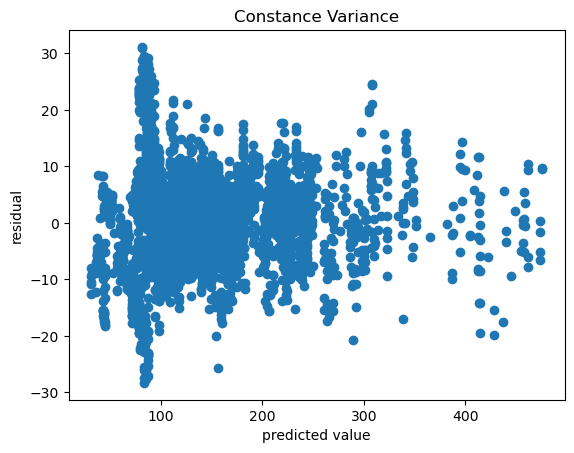

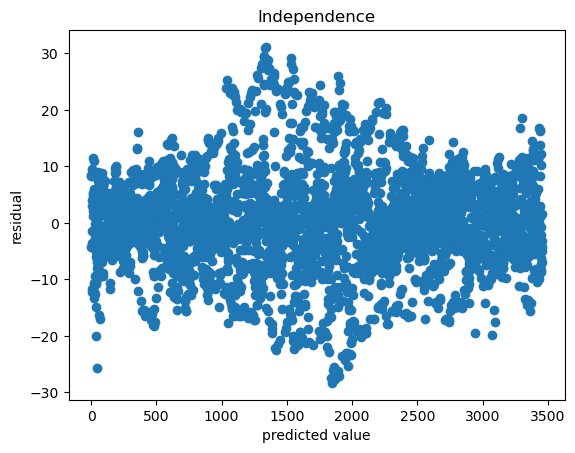

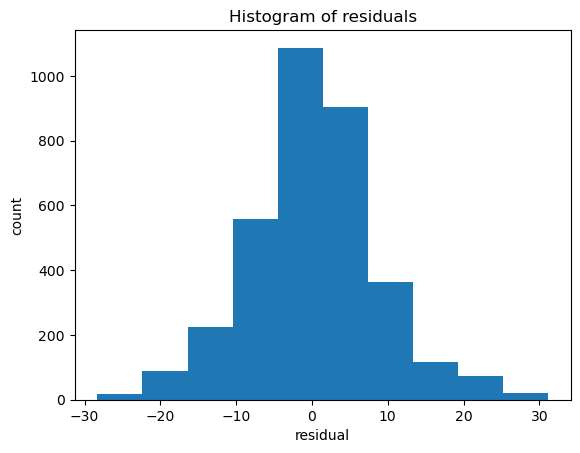

In [130]:
results = plots_and_results(data_df.Date, data_df.Predicted, data_df.Actual)

MSE: 32.37387958262543, R2: 0.986012537408389


C:\Users\milol\AppData\Local\Temp\ipykernel_22952\1763372668.py:25: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\milol\AppData\Local\Temp\ipykernel_22952\1763372668.py:33: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\milol\AppData\Local\Temp\ipykernel_22952\1763372668.py:40: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



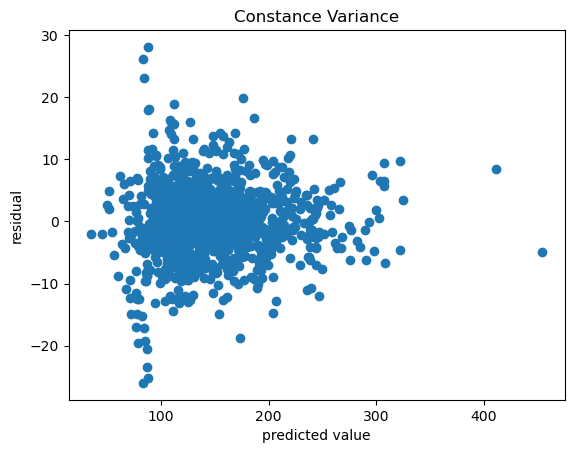

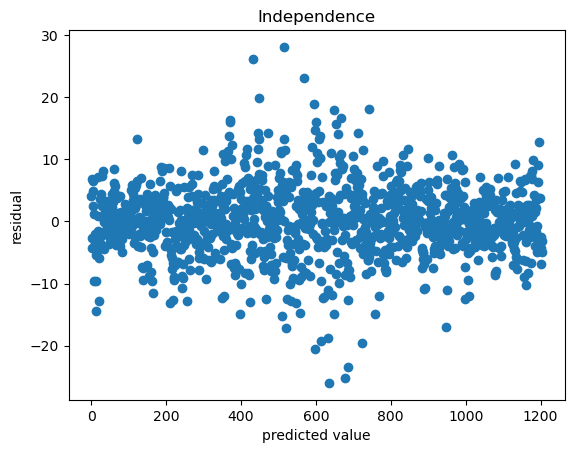

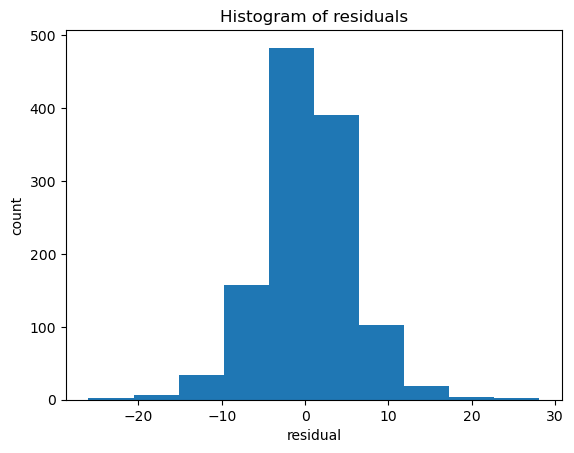

In [132]:
comp = data_df[['Date', 'Predicted', 'Actual']]
comp = comp.groupby('Date').mean().reset_index()
comp_results = plots_and_results(comp.Date, comp.Predicted, comp.Actual)